# Python Notebook for Facial Expression Classification Model-1

In this notebook, our first classification model is defined and trained and then validated by our validation dataset.

## Dowloading Data (FER 2013):

Installing **Kaggle** Package Manager for downloading data from Kaggle.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we are making directory where we want to place **kaggle.json** so that kaggle package can get permission to download the dataset.

In [ ]:
! mkdir ~/.kaggle

Copy the **kaggle.json** to our created directory.

In [ ]:
!cp kaggle.json ~/.kaggle/

Adding Security permissions to the file.

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Download the dataset in zip format.

In [ ]:
!kaggle datasets download -d msambare/fer2013

 98% 59.0M/60.3M [00:02<00:00, 29.6MB/s]
100% 60.3M/60.3M [00:02<00:00, 23.1MB/s]


Unzip the data in the root folder.

In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

## Importing Libraries:

Here are the some required libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Transformations and Data Loaders:

This code defines some image transformations using PyTorch's transforms module for the training dataset. The mean and std variables define the mean and standard deviation for normalization of the image pixels.

The train_transforms variable is a Compose object that chains together multiple image transformations to be applied sequentially to each training image. The transformations applied in this example are:

    RandomAffine: randomly applies affine transformations to the image, such as rotation, translation, and scaling
    RandomHorizontalFlip: randomly flips the image horizontally
    RandomVerticalFlip: randomly flips the image vertically
    ToTensor: converts the image to a PyTorch tensor
    Normalize: normalizes the tensor values using the specified mean and std values

Each transformation is applied in the order they are listed in the Compose object.

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
train_transforms = transforms.Compose([transforms.RandomAffine(degrees = 10, translate = (0.1, 0.1)), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ToTensor(), transforms.Normalize(mean, std)])

This code loads the training and test datasets and creates data loaders for them.

The ImageFolder function from torchvision.datasets is used to create datasets from images in directories. In this case, the training and test images are located in ./train and ./test directories, respectively. The transform argument specifies the transformations to be applied to the images, which are defined in the train_transforms variable for the training dataset, and a separate set of ToTensor and Normalize transformations for the test dataset.

The DataLoader function from torch.utils.data is used to create data loaders that can load the data in batches during training and testing. The batch_size argument specifies the number of images in each batch, and the shuffle argument indicates whether the data should be shuffled before each epoch. The training and test loaders are created separately, with different batch sizes, but both with shuffling enabled.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('./train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./test', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]))

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
len(train_dataset)

28709

In [ ]:
images, labels = next(iter(train_loader))
input_features = images.shape[1]
batch_size = images.shape[0]
out_features = labels.shape[0]
hidden_features = 16
images.shape

torch.Size([500, 3, 48, 48])

Here is the dictionary for converting index to classes and classes to index.

In [ ]:
class2index = train_dataset.class_to_idx
index2class = dict([(value, key) for key, value in class2index.items()])

In [ ]:
index2class

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

Here is the pictorial representaion of images in our dataset

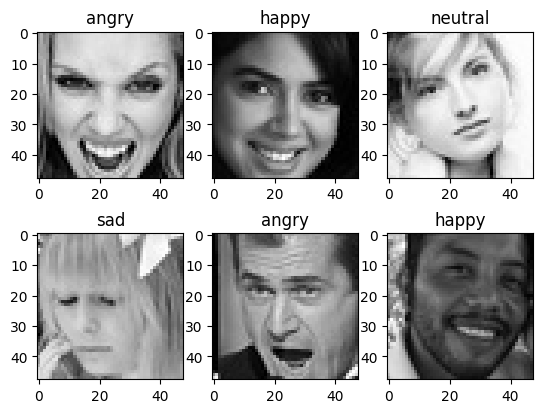

In [ ]:
images, labels = next(iter(test_loader))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[labels[i].item()])
plt.show()

## Model Creation:

This code defines a Convolutional Neural Network (CNN) model for classifying facial expressions.

The CNNModel class is a subclass of nn.Module, and defines the layers and operations of the neural network. It takes four arguments: input, the number of input channels; hidden, a list of integers specifying the number of output channels for each of the four convolutional layers; output, the number of output classes; and kernel_size, the size of the convolutional kernel.

The __init__ method initializes the layers of the neural network. It defines four convolutional layers (layer1-layer4) with batch normalization layers (bn1-bn4) and a max pooling layer (pool). It also defines three fully connected layers (layer5-layer7) with batch normalization layers (bn5-bn7). The final layer (layer8) has output output nodes.

The forward method defines the forward pass of the neural network. It applies the convolutional and fully connected layers in sequence, with batch normalization and ReLU activation functions applied to the output of each layer, except for the final layer where no activation function is applied. The output of the final layer is returned as the output of the forward pass.
<br><br><br>
The **Pictorial Represention** of the Model is given below:
<br><br>
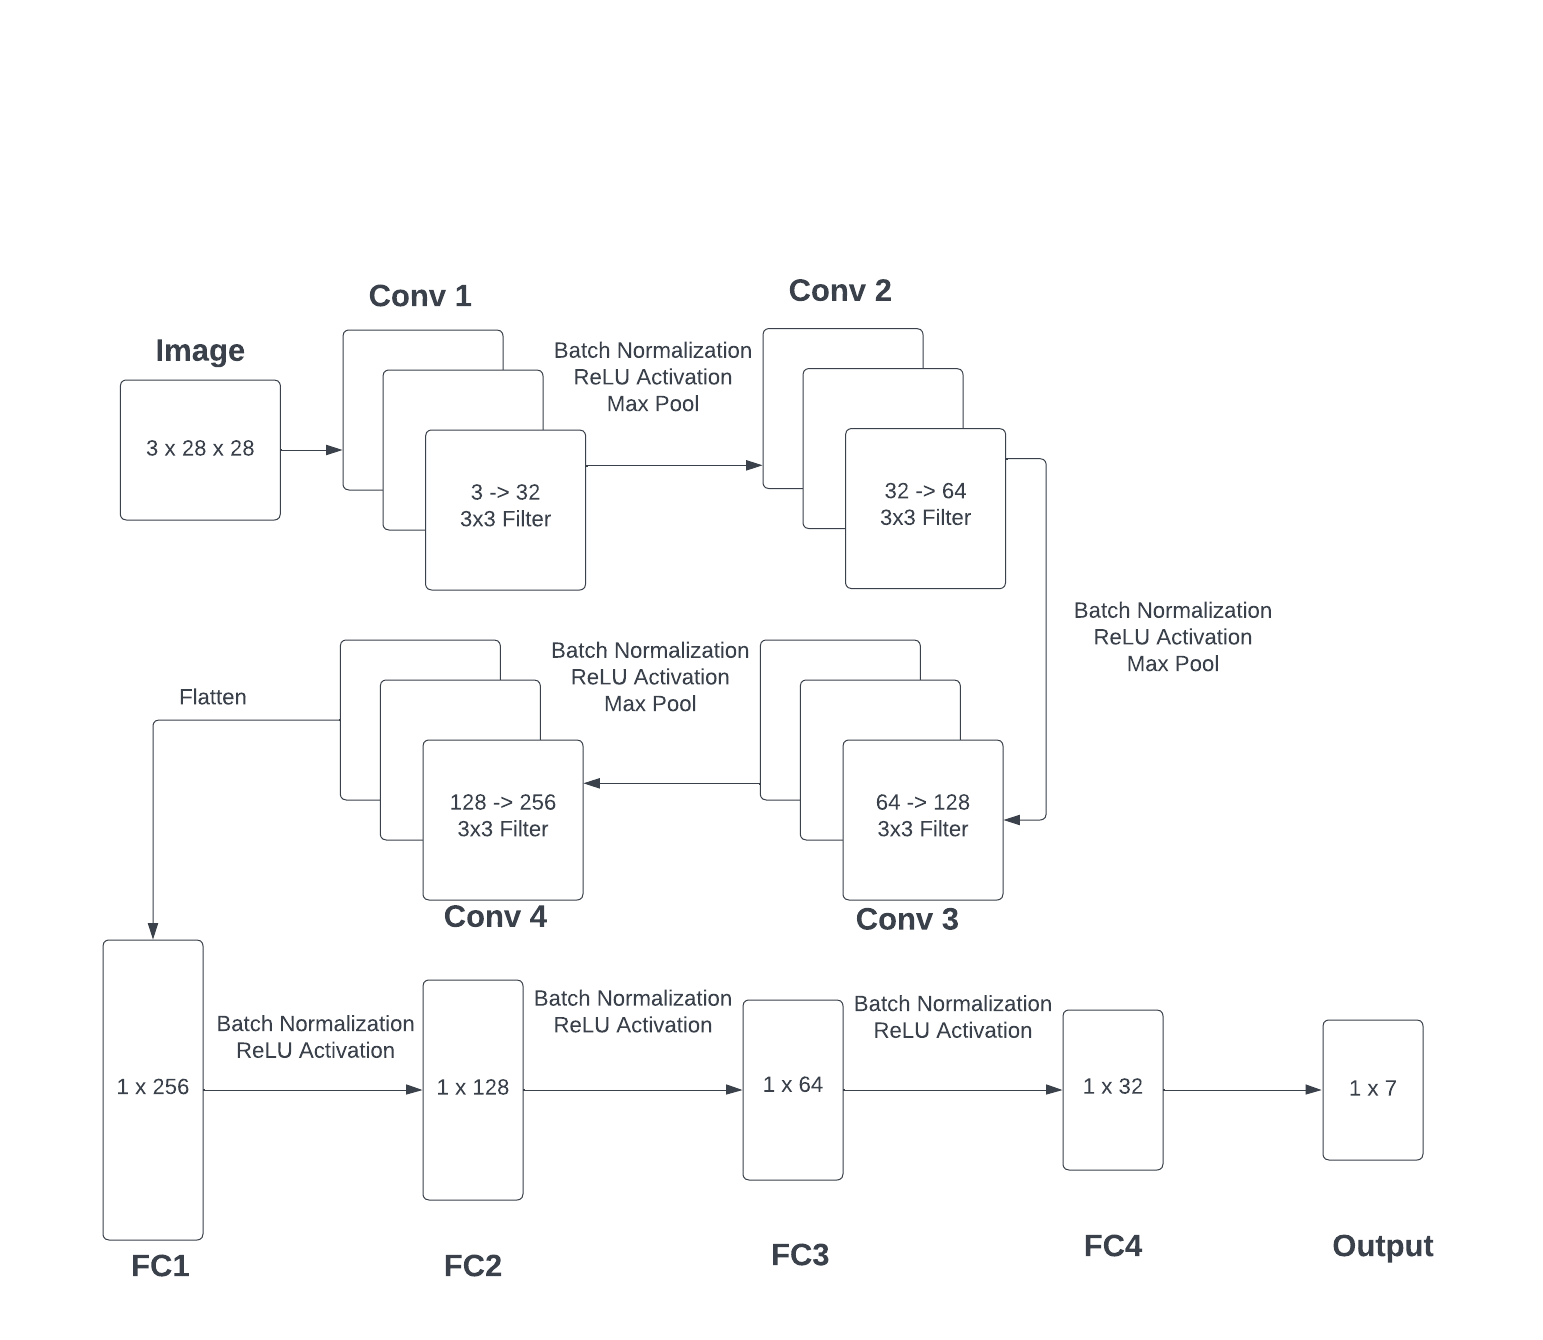


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, input, hidden, output, kernel_size):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.layer1 = nn.Conv2d(input, hidden[0], kernel_size)
        self.bn1 = nn.BatchNorm2d(hidden[0])
        self.layer2 = nn.Conv2d(hidden[0], hidden[1], kernel_size)
        self.bn2 = nn.BatchNorm2d(hidden[1])
        self.layer3 = nn.Conv2d(hidden[1], hidden[2], kernel_size)
        self.bn3 = nn.BatchNorm2d(hidden[2])
        self.layer4 = nn.Conv2d(hidden[2], hidden[3], kernel_size)
        self.bn4 = nn.BatchNorm2d(hidden[3])
        self.layer5 = nn.Linear(hidden[3], 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.layer6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.layer7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(32)
        self.layer8 = nn.Linear(32, output)

    def forward(self, X):
        l1 = self.pool(F.relu(self.bn1(self.layer1(X))))
        l2 = self.pool(F.relu(self.bn2(self.layer2(l1))))
        l3 = self.pool(F.relu(self.bn3(self.layer3(l2))))
        l4 = self.pool(F.relu(self.bn4(self.layer4(l3))))
        flattened = l4.view(-1, 256)
        l5 = F.relu(self.bn5(self.layer5(flattened)))
        l6 = F.relu(self.bn6(self.layer6(l5)))
        l7 = F.relu(self.bn7(self.layer7(l6)))
        l8 = self.layer8(l7)
        return l8

## Model Training:

The given code defines a convolutional neural network (CNN) model using PyTorch library to perform image classification. The CNN model consists of 8 layers, which include 4 convolutional layers, 3 fully connected layers, and a final output layer. The input to the model is an image, and the output is a probability distribution over 7 classes. The model uses the Rectified Linear Unit (ReLU) activation function to introduce non-linearity, and the Max Pooling operation is used to reduce the spatial size of the feature maps.

The code then trains the model on a training dataset and validates it on a test dataset for a specified number of epochs. During each epoch, the model is first set to training mode and trained on batches of data using stochastic gradient descent (SGD) optimizer with a cross-entropy loss function. Then, the model is set to evaluation mode and evaluated on the test dataset to calculate its accuracy.

The history dictionary is used to store the loss and accuracy values during the training process. The best model is saved based on the lowest loss and highest accuracy values achieved during the training process.

Overall, the given code is an implementation of a CNN model using PyTorch for image classification, with training and validation on a dataset, and a mechanism to save the best model based on loss and accuracy.

In [ ]:
learning_rate = 0.01
model = CNNModel(input_features, [32, 64, 128, 256], 7, 3).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 100
history = {
    "Loss": [],
    "Accuracy": []
}

best_loss = float('inf')
best_acc = 0.0

for epoch in range(epochs):
    model.train()  # Set model to training mode

    acc_loss = 0
    for i, (input, labels) in enumerate(train_loader):
        input = input.to(device)
        labels = labels.to(device)

        y_pred = model(input)
        l = loss(y_pred, labels)
        acc_loss += l.item()

        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    avg_loss = acc_loss / len(train_dataset)  # Calculate average loss per sample
    history['Loss'].append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}]:")
    print(f"Train Loss: {avg_loss:.3f}")

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        n_correct = 0
        for input, labels in test_loader:
            input = input.to(device)
            labels = labels.to(device)
            y_pred_test = model(input)
            _, index = torch.max(y_pred_test, 1)
            n_correct += (labels == index).sum().item()
        acc = n_correct / len(test_dataset)  # Calculate accuracy on test dataset
        print(f"Test Accuracy: {acc:.3f}")
        history['Accuracy'].append(acc)

        # Save model based on loss and accuracy
        if avg_loss < best_loss and acc > best_acc:
            best_loss = avg_loss
            best_acc = acc
            torch.save(model.state_dict(), "best_model_loss.pth")
            print("Best model saved!")

Epoch [1/100]:
Train Loss: 0.004
Test Accuracy: 0.248
Best model saved!
Epoch [2/100]:
Train Loss: 0.004
Test Accuracy: 0.288
Best model saved!
Epoch [3/100]:
Train Loss: 0.004
Test Accuracy: 0.311
Best model saved!
Epoch [4/100]:
Train Loss: 0.004
Test Accuracy: 0.312
Best model saved!
Epoch [5/100]:
Train Loss: 0.003
Test Accuracy: 0.328
Best model saved!
Epoch [6/100]:
Train Loss: 0.003
Test Accuracy: 0.336
Best model saved!
Epoch [7/100]:
Train Loss: 0.003
Test Accuracy: 0.371
Best model saved!
Epoch [8/100]:
Train Loss: 0.003
Test Accuracy: 0.297
Epoch [9/100]:
Train Loss: 0.003
Test Accuracy: 0.341
Epoch [10/100]:
Train Loss: 0.003
Test Accuracy: 0.370
Epoch [11/100]:
Train Loss: 0.003
Test Accuracy: 0.387
Best model saved!
Epoch [12/100]:
Train Loss: 0.003
Test Accuracy: 0.421
Best model saved!
Epoch [13/100]:
Train Loss: 0.003
Test Accuracy: 0.396
Epoch [14/100]:
Train Loss: 0.003
Test Accuracy: 0.433
Best model saved!
Epoch [15/100]:
Train Loss: 0.003
Test Accuracy: 0.432


## Model Testing:

Here are the cells that calculates the overall accuracy and then plot the training cycle of the given model.

In [ ]:
with torch.no_grad():
  n_correct = 0
  for input, labels in test_loader:
    input = input.to(device)
    labels = labels.to(device)
    y_pred_test = model(input)
    _, index = torch.max(y_pred_test, 1)
    n_correct += (labels == index).sum().item()
  acc = n_correct/(len(test_loader)*100)
  print(f"Accuracy :: {acc}")

In [ ]:
model.eval()
images, labels = next(iter(test_loader))
for i in range(6):
  input = images[i].to(device)
  input = torch.unsqueeze(input, axis=0)
  y_pred_test = model(input)
  value, index = torch.max(y_pred_test, 1)
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[index.item()])
plt.show()

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()


## Load Our Saved Model and Test:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
checkpoint = torch.load('/content/gdrive/MyDrive/best_model_loss.pth', map_location=torch.device('cpu'))
load_model = CNNModel(input_features, [32, 64, 128, 256], 7, 3).to(device)
load_model.load_state_dict(checkpoint)

<All keys matched successfully>

### Test on Real Life Data:

Take a picture from laptop, resize it to 28x28 and then fed it to the model for prediction

In [ ]:
import cv2

# Load image using OpenCV
image_path = 'face_image.jpg'  # Replace with the path to your image file
image = cv2.imread(image_path)

# Convert image to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert image to PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image)

# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)

tensor([[ 0.7432, -3.1044,  0.1261,  0.3835,  0.8982,  0.3489,  0.0263]],
       grad_fn=<AddmmBackward0>)


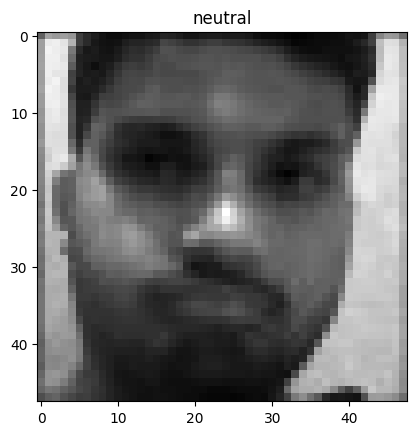

In [ ]:
load_model.eval()
y_pred_test = load_model(image_tensor)
print(y_pred_test)
value, index = torch.max(y_pred_test, 1)
plt.imshow(image_tensor[0][0], cmap="gray")
plt.title(index2class[index.item()])
plt.show()

Here we test it on our testing dataset.

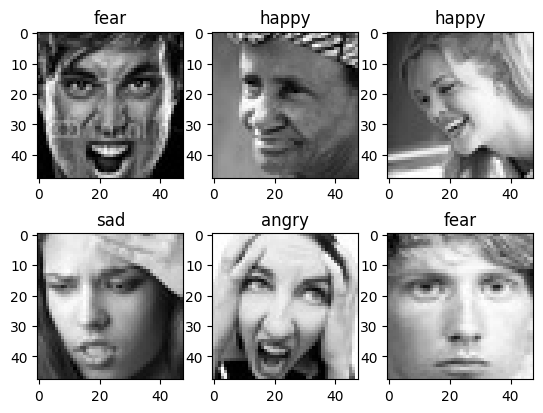

In [ ]:
load_model.eval()
images, labels = next(iter(test_loader))
for i in range(6):
  input = images[i].to(device)
  input = torch.unsqueeze(input, axis=0)
  y_pred_test = load_model(input)
  value, index = torch.max(y_pred_test, 1)
  plt.subplot(2, 3, i+1)
  plt.imshow(images[i][0], cmap="gray")
  plt.title(index2class[index.item()])
plt.show()